Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [2]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36


In [3]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [4]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [5]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))

0.0 1.0
0.0 1.0
0.0 1.0


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [6]:
from scipy.stats import norm
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
## function which map object to probability distribution ##

def bin_counts(real_data, generated_data, number_of_bins=25):
    # Flatten the data
    real_data = real_data.flatten()
    generated_data = generated_data.flatten()
    x = np.linspace(0, 1, 1000)
    # binirize real and generated data, plot histogram and found density function
    plt.figure()
    plt.hist(real_data, bins=number_of_bins, color='g', density=True, stacked=True)
    real_density = norm.pdf(x, np.mean(real_data), np.std(real_data))
    plt.plot(x, real_density, 'k', linewidth=2)
    plt.title("Real Data Distribution")
    plt.show()
    
    plt.figure()
    plt.hist(generated_data.flatten(), bins=number_of_bins, color='b', density=True)
    gen_density = norm.pdf(x, np.mean(generated_data), np.std(generated_data))
    plt.plot(x, gen_density, 'k', linewidth=2)
    plt.title("Generated Data Distribution")
    plt.show()
    
    # Fit a normal distribution to the data:
    return real_density / real_density.sum(), gen_density / gen_density.sum()

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [7]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    # you code
    for angle in angles:
        alpha = np.minimum(angle * real_density, gen_density).sum()
        alpha_vec.append(alpha)
        beta = np.minimum(real_density, gen_density / angle).sum()
        beta_vec.append(beta)
    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [8]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print (vectors.shape)
    return vectors

## 2. Apply it##

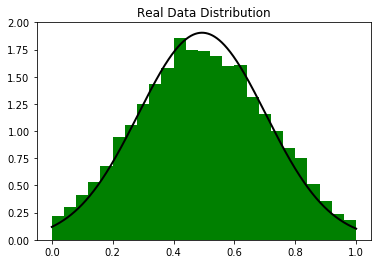

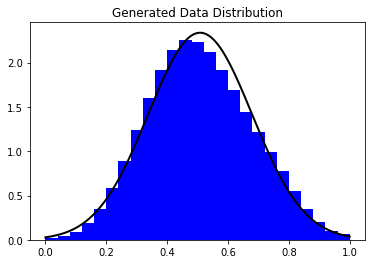

In [9]:
a, b = bin_counts(real_data.image, vae_data.image)

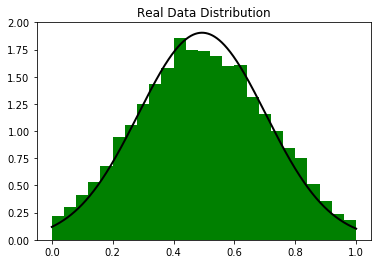

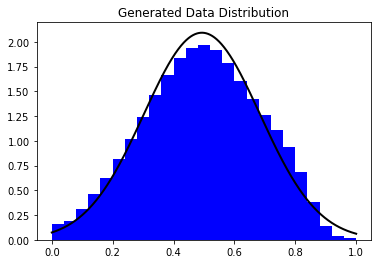

In [10]:
c, d = bin_counts(real_data.image, gan_data.image)

## 3. Make vectors for plot and plot ##

In [11]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

(2, 1000)
(2, 1000)


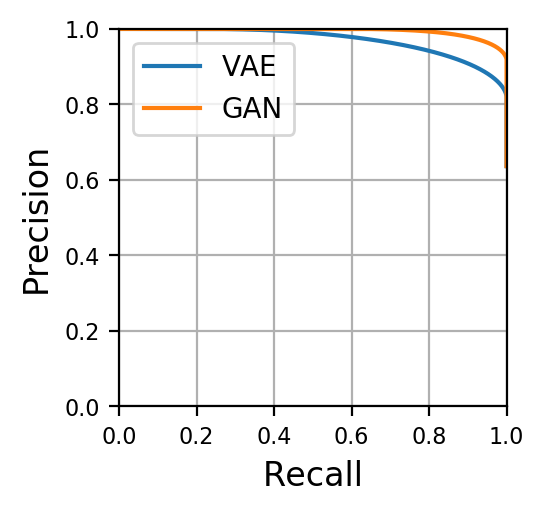

In [12]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.grid()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

PRD (Precision and Recall for Distributions) curves were obtained for VAE and GAN models. Using them, one can evaluate performance of the given generative models. This quote from the original paper explains the intuition behind it: 

``...precision and recall to compare a distribution Q to a reference distribution P. The key intuition is that precision should measure how much of Q can be generated by a “part” of P while recall should measure how much of P can be generated by a “part” of Q. 
``

Seems like in this case GAN both learned the original (real) distribution more accurately and generates images from it more diversely than VAE.

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [13]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
